# Homework 3 - Computer Vision Seminar
## Aseel Khawaled - 211752969
## George Jobran - 211622600

# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-514qm4jr
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-514qm4jr
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.6 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=af756cacff4598d369d2f6a8c80acf4371f7d8b6997001e41bcadf010124dda4
  Stored in directory: /tmp/pip-ephem-wheel-cache-9vb5ud8o/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [3]:
import os
import shutil
import random
import zipfile
import torch
import clip
import random
import numpy as np
from tqdm import tqdm
from PIL import Image
from torch.utils.data import Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


# Part 1: Cropping Cow Faces Using YOLOV8

## Preparation for YOLOV8

We uploaded 100 images to Makesense.ai, this website allows us to upload images, and choose bounding boxes and label them, then afterwards we can export them in the YOLO format to use in training YOLOV8, that is reflected in the code below in the <br> **labels_my-project-name_2024-09-19-08-42-48.zip** <br>
file, which contains .txt files in the YOLO format for the initial 100 images, then we fine-tune YOLOV8 and run it, and the output of it we go over it and choose good croppings and add them to the training data, we did this a couple of times, in the end the training data is around 250 images of cropped cow faces,which we split into training and validation sets and that is the final amount we used to fine-tune YOLOV8

In [4]:
import os
import zipfile
import random
import shutil

# Paths
zip_file_path = '/content/drive/MyDrive/CV_EX3_211752969_211622600/yolo_trainData/labels_my-project-name_2024-09-19-08-42-48.zip'
images_folder = '/content/drive/MyDrive/CV_EX3_211752969_211622600/yolo_trainData/images'
output_folder = '/content/drive/MyDrive/CV_EX3_211752969_211622600/yolo_trainData/split_dataset/'

# Create output directories
train_images_dir = os.path.join(output_folder, 'images/train/')
val_images_dir = os.path.join(output_folder, 'images/val/')
test_images_dir = os.path.join(output_folder, 'images/test/')
train_labels_dir = os.path.join(output_folder, 'labels/train/')
val_labels_dir = os.path.join(output_folder, 'labels/val/')
test_labels_dir = os.path.join(output_folder, 'labels/test/')

# Ensure output directories exist
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(test_images_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)
os.makedirs(test_labels_dir, exist_ok=True)

# Extract label files from the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/CV_EX3_211752969_211622600/yolo_trainData/temp_labels/')

# Path to the extracted labels folder
labels_folder = '/content/drive/MyDrive/CV_EX3_211752969_211622600/yolo_trainData/temp_labels/'

# Get list of all label files
label_files = [f for f in os.listdir(labels_folder) if f.endswith('.txt')]

# Shuffle and split the dataset (70% train, 15% val, 15% test)
random.shuffle(label_files)
train_split = int(0.7 * len(label_files))
val_split = int(0.85 * len(label_files))

train_labels = label_files[:train_split]
val_labels = label_files[train_split:val_split]
test_labels = label_files[val_split:]

# Function to move files to the corresponding folder
def move_files(label_list, image_folder, label_folder, image_dest, label_dest):
    for label_file in label_list:
        # Get image file name from label file (assuming the image has the same name but different extension)
        image_file = label_file.replace('.txt', '.jpg')  # Change extension based on your image format (e.g., .png, .jpg)

        # Check if both image and label files exist
        if os.path.exists(os.path.join(image_folder, image_file)) and os.path.exists(os.path.join(label_folder, label_file)):
            # Copy image and label to the respective train/val/test folder
            shutil.copy(os.path.join(image_folder, image_file), os.path.join(image_dest, image_file))
            shutil.copy(os.path.join(label_folder, label_file), os.path.join(label_dest, label_file))

# Move train, validation, and test files
move_files(train_labels, images_folder, labels_folder, train_images_dir, train_labels_dir)
move_files(val_labels, images_folder, labels_folder, val_images_dir, val_labels_dir)
move_files(test_labels, images_folder, labels_folder, test_images_dir, test_labels_dir)

# Check how many files were moved to each directory
len(train_labels), len(val_labels), len(test_labels)


(175, 38, 38)

## Fine-Tuning YOLOV8

In [5]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.8/898.8 kB 21.4 MB/s eta 0:00:00


In [6]:
import torch
print('GPU available:', torch.cuda.is_available())

GPU available: True


In [7]:
from ultralytics import YOLO

# Load YOLOv8 model, here 'yolov8n' is the model size (you can also use 'yolov8s', 'yolov8m', 'yolov8l', etc.)
model = YOLO('yolov8n.pt')  # Pretrained model

# Train the model using your dataset.yaml file
model.train(data='/content/drive/MyDrive/CV_EX3_211752969_211622600/yolo_trainData/dataset.yaml', epochs=100, imgsz=640, batch=16)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 121MB/s]


Ultralytics 8.3.48 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/CV_EX3_211752969_211622600/yolo_trainData/dataset.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop

100%|██████████| 755k/755k [00:00<00:00, 26.9MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 76.6MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/CV_EX3_211752969_211622600/yolo_trainData/split_dataset/labels/train.cache... 251 images, 0 backgrounds, 0 corrupt: 100%|██████████| 251/251 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/MyDrive/CV_EX3_211752969_211622600/yolo_trainData/split_dataset/labels/val... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [02:32<00:00,  1.16it/s]

val: New cache created: /content/drive/MyDrive/CV_EX3_211752969_211622600/yolo_trainData/split_dataset/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.15G      1.344      2.589      1.605         30        640: 100%|██████████| 16/16 [00:13<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:09<00:00,  1.56s/it]

                   all        177        178          1      0.144      0.937      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.14G      1.099      1.529      1.316         23        640: 100%|██████████| 16/16 [00:05<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.22it/s]

                   all        177        178      0.926      0.282      0.714      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.15G      1.135       1.36      1.321         21        640: 100%|██████████| 16/16 [00:09<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]


                   all        177        178       0.76      0.728      0.819      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.15G      1.121      1.323      1.295         26        640: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.28it/s]

                   all        177        178      0.784      0.735      0.833      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.15G      1.135      1.282      1.288         27        640: 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.09it/s]

                   all        177        178      0.683       0.77      0.776      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.14G      1.211       1.31      1.326         39        640: 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.19it/s]


                   all        177        178      0.253      0.163      0.132     0.0434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.14G       1.19       1.28      1.341         30        640: 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.22it/s]

                   all        177        178       0.67      0.618      0.695      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.14G      1.187      1.181      1.303         23        640: 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.22it/s]

                   all        177        178      0.805      0.787       0.87      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.14G       1.08      1.073      1.252         24        640: 100%|██████████| 16/16 [00:09<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.37it/s]


                   all        177        178      0.726      0.641      0.755      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.14G      1.149      1.026      1.308         23        640: 100%|██████████| 16/16 [00:06<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.27it/s]

                   all        177        178      0.705      0.736      0.767      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.14G      1.138     0.9757       1.26         28        640: 100%|██████████| 16/16 [00:05<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.41it/s]


                   all        177        178      0.706      0.635      0.679      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.14G      1.093     0.9676      1.248         22        640: 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]


                   all        177        178      0.835      0.796      0.869      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.14G      1.182      1.015      1.311         24        640: 100%|██████████| 16/16 [00:06<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.48it/s]

                   all        177        178      0.814      0.787      0.865      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.14G       1.09     0.9153      1.237         30        640: 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.35it/s]


                   all        177        178      0.925      0.896      0.953      0.638

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.14G      1.054     0.8454      1.216         30        640: 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.95it/s]

                   all        177        178      0.929      0.885      0.937      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.14G      1.061      0.812      1.236         22        640: 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.43it/s]

                   all        177        178      0.913      0.921      0.974      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.14G     0.9875     0.7761      1.189         31        640: 100%|██████████| 16/16 [00:07<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.35it/s]


                   all        177        178      0.917      0.753      0.895      0.627

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.14G     0.9773     0.7529      1.166         21        640: 100%|██████████| 16/16 [00:09<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.66it/s]

                   all        177        178      0.979      0.921      0.974      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.14G     0.9711     0.7466      1.186         24        640: 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.97it/s]

                   all        177        178      0.971      0.949      0.988      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.14G      1.032     0.7908      1.202         27        640: 100%|██████████| 16/16 [00:08<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        177        178      0.929      0.966      0.977      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.13G      1.009     0.7487      1.199         30        640: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.35it/s]

                   all        177        178      0.961      0.964      0.973      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.13G     0.9544     0.7064       1.16         23        640: 100%|██████████| 16/16 [00:06<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.41it/s]


                   all        177        178      0.939      0.949      0.961       0.74

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.14G     0.9185     0.7026      1.154         27        640: 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.20it/s]

                   all        177        178      0.971      0.954      0.977      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.13G     0.9676     0.7114      1.162         29        640: 100%|██████████| 16/16 [00:07<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.28it/s]


                   all        177        178      0.987      0.938      0.979      0.743

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.13G      0.948     0.6674      1.156         23        640: 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

                   all        177        178      0.936      0.897      0.952      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.14G     0.9895      0.711      1.168         29        640: 100%|██████████| 16/16 [00:09<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.72it/s]

                   all        177        178      0.959      0.911      0.976      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.14G     0.9594     0.6607      1.139         27        640: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]

                   all        177        178      0.989      0.975      0.991      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.14G     0.9516     0.6592       1.15         28        640: 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.33it/s]

                   all        177        178      0.968      0.966      0.986      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.13G      0.898     0.6373      1.125         27        640: 100%|██████████| 16/16 [00:09<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.21it/s]

                   all        177        178      0.971      0.972      0.992      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.14G     0.9186     0.6144      1.133         29        640: 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.28it/s]

                   all        177        178      0.972      0.972      0.991      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.14G     0.8687     0.6058      1.123         19        640: 100%|██████████| 16/16 [00:06<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.19it/s]

                   all        177        178       0.97      0.989      0.988        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.14G     0.8327     0.5724      1.084         28        640: 100%|██████████| 16/16 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

                   all        177        178      0.973      0.949      0.983      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.14G     0.8908     0.6259       1.14         32        640: 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.35it/s]

                   all        177        178      0.974      0.944       0.98      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.14G     0.8569     0.5852      1.106         30        640: 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.35it/s]

                   all        177        178      0.958      0.961       0.98      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.14G     0.8558     0.5757      1.118         21        640: 100%|██████████| 16/16 [00:09<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.65it/s]

                   all        177        178      0.984      0.961      0.988       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.14G     0.8695     0.5844      1.102         24        640: 100%|██████████| 16/16 [00:05<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.78it/s]

                   all        177        178      0.982      0.972      0.984      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.14G     0.8779     0.5838      1.101         29        640: 100%|██████████| 16/16 [00:08<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        177        178      0.953      0.904      0.957       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.14G     0.8809     0.6051      1.144         26        640: 100%|██████████| 16/16 [00:08<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.34it/s]

                   all        177        178      0.923      0.854      0.946      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.14G      0.851     0.5739      1.107         34        640: 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.84it/s]

                   all        177        178      0.927       0.91       0.95      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.14G     0.8322     0.5347      1.101         25        640: 100%|██████████| 16/16 [00:09<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.73it/s]

                   all        177        178      0.972      0.966      0.983        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.14G     0.8094      0.521      1.079         25        640: 100%|██████████| 16/16 [00:08<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.42it/s]

                   all        177        178      0.964      0.944      0.972      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.14G     0.7895      0.533      1.068         30        640: 100%|██████████| 16/16 [00:05<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.14it/s]

                   all        177        178      0.979      0.972       0.99      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.14G     0.7693     0.5079      1.072         22        640: 100%|██████████| 16/16 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]

                   all        177        178      0.988      0.978      0.994      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.14G     0.7596     0.4979      1.065         24        640: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.43it/s]

                   all        177        178      0.994      0.988      0.994      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.14G     0.8273     0.5178      1.084         29        640: 100%|██████████| 16/16 [00:06<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]

                   all        177        178      0.985      0.983      0.994      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.14G     0.7812      0.499      1.073         28        640: 100%|██████████| 16/16 [00:09<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.22it/s]


                   all        177        178      0.994      0.983      0.995      0.862

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.14G     0.7827      0.515      1.086         24        640: 100%|██████████| 16/16 [00:06<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]


                   all        177        178      0.986      0.989      0.994       0.86

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.14G     0.7506     0.4982      1.056         24        640: 100%|██████████| 16/16 [00:08<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        177        178      0.989      0.989      0.992      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.14G     0.7569     0.5068      1.061         26        640: 100%|██████████| 16/16 [00:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.48it/s]

                   all        177        178      0.994      0.994      0.995      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.14G     0.7371       0.49      1.062         20        640: 100%|██████████| 16/16 [00:06<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.87it/s]

                   all        177        178      0.994      0.994      0.995      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.14G     0.7861     0.5098      1.079         25        640: 100%|██████████| 16/16 [00:08<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

                   all        177        178      0.989      0.989      0.995      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.14G     0.7366     0.4906      1.044         25        640: 100%|██████████| 16/16 [00:07<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.36it/s]

                   all        177        178      0.994      0.994      0.995       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.14G     0.7658     0.4849      1.073         21        640: 100%|██████████| 16/16 [00:05<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.58it/s]


                   all        177        178      0.994      0.989      0.993       0.86

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.14G     0.7489     0.4771      1.047         32        640: 100%|██████████| 16/16 [00:09<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.37it/s]

                   all        177        178      0.999      0.989      0.995      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.14G      0.698     0.4562      1.011         29        640: 100%|██████████| 16/16 [00:07<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]

                   all        177        178          1      0.976      0.986      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.14G     0.7407     0.4802      1.046         30        640: 100%|██████████| 16/16 [00:06<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.59it/s]

                   all        177        178      0.991      0.983      0.994      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.14G     0.7336     0.4791      1.059         31        640: 100%|██████████| 16/16 [00:09<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.44it/s]

                   all        177        178      0.988      0.983      0.992      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.14G     0.7126     0.4465      1.034         28        640: 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.40it/s]


                   all        177        178      0.994      0.989      0.994      0.875

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.14G      0.706     0.4306      1.031         20        640: 100%|██████████| 16/16 [00:05<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.37it/s]

                   all        177        178      0.999      0.983      0.991      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.14G     0.6916      0.428      1.018         24        640: 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.91it/s]


                   all        177        178      0.994      0.994      0.995      0.891

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.14G     0.6725     0.4086      1.003         20        640: 100%|██████████| 16/16 [00:05<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.55it/s]

                   all        177        178      0.998      0.994      0.995      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.14G     0.6802      0.428      1.016         24        640: 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

                   all        177        178          1      0.994      0.995      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.14G     0.6995      0.437      1.034         22        640: 100%|██████████| 16/16 [00:08<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.55it/s]

                   all        177        178      0.997      0.994      0.995      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.14G     0.6536      0.422     0.9971         25        640: 100%|██████████| 16/16 [00:06<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.67it/s]

                   all        177        178      0.993      0.994      0.995      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.14G     0.6637     0.4416      1.022         31        640: 100%|██████████| 16/16 [00:08<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.50it/s]

                   all        177        178      0.994      0.993      0.995       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.14G     0.7321     0.4496      1.047         31        640: 100%|██████████| 16/16 [00:07<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.25it/s]

                   all        177        178      0.994      0.994      0.995      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.14G     0.6657     0.4204      1.011         33        640: 100%|██████████| 16/16 [00:05<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.40it/s]

                   all        177        178      0.993      0.994      0.995      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.14G     0.6509     0.3976      1.007         26        640: 100%|██████████| 16/16 [00:09<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.39it/s]

                   all        177        178      0.994      0.994      0.995      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.14G     0.6508     0.4178      1.013         22        640: 100%|██████████| 16/16 [00:07<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.24it/s]

                   all        177        178      0.998      0.994      0.995      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.14G     0.6566     0.4163      1.024         25        640: 100%|██████████| 16/16 [00:05<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.43it/s]

                   all        177        178          1      0.994      0.995      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.14G     0.6234     0.3789      0.994         29        640: 100%|██████████| 16/16 [00:09<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.36it/s]

                   all        177        178      0.999      0.994      0.995      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.14G     0.6243     0.3986     0.9889         29        640: 100%|██████████| 16/16 [00:07<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.54it/s]

                   all        177        178      0.999      0.994      0.995      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.14G     0.6332     0.3904      1.003         21        640: 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.21it/s]

                   all        177        178      0.997      0.994      0.995      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.14G     0.6693     0.4196      1.016         32        640: 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        177        178      0.994      0.994      0.995        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.14G     0.6398     0.3962     0.9965         24        640: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.45it/s]

                   all        177        178      0.996      0.994      0.995       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.14G     0.6048     0.3843     0.9802         25        640: 100%|██████████| 16/16 [00:06<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        177        178      0.999      0.994      0.995      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.14G     0.6192     0.3821     0.9994         25        640: 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.18it/s]

                   all        177        178      0.999      0.994      0.995      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.14G     0.5698     0.3593     0.9795         27        640: 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.35it/s]

                   all        177        178          1      0.994      0.995      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.14G     0.6225     0.3934      1.016         28        640: 100%|██████████| 16/16 [00:06<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        177        178          1      0.994      0.995      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.14G     0.6139     0.3825     0.9884         17        640: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.73it/s]

                   all        177        178          1      0.994      0.995      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.14G     0.5727     0.3596     0.9762         25        640: 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.66it/s]

                   all        177        178          1      0.994      0.995      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.14G     0.5622     0.3605     0.9591         32        640: 100%|██████████| 16/16 [00:08<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        177        178      0.999      0.994      0.995      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.14G     0.5727     0.3486      0.967         21        640: 100%|██████████| 16/16 [00:07<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.28it/s]

                   all        177        178      0.999      0.994      0.995      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.14G     0.5779     0.3593     0.9727         32        640: 100%|██████████| 16/16 [00:06<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.18it/s]

                   all        177        178          1      0.994      0.995      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.14G     0.5677     0.3623     0.9713         24        640: 100%|██████████| 16/16 [00:09<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

                   all        177        178          1      0.994      0.995       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.14G     0.5777     0.3623     0.9851         25        640: 100%|██████████| 16/16 [00:07<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.32it/s]

                   all        177        178          1      0.994      0.995      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.14G     0.5608     0.3654     0.9632         19        640: 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.33it/s]

                   all        177        178          1      0.994      0.995      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.14G     0.5635     0.3576     0.9659         21        640: 100%|██████████| 16/16 [00:09<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.41it/s]

                   all        177        178          1      0.994      0.995       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.14G     0.5532     0.3503     0.9712         23        640: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]

                   all        177        178          1      0.994      0.995      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.14G     0.5627     0.3481     0.9645         23        640: 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.17it/s]

                   all        177        178          1      0.994      0.995      0.934


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.14G     0.4783      0.322     0.8959         11        640: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.63it/s]

                   all        177        178          1      0.994      0.995      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.14G     0.4481     0.2733     0.8704         11        640: 100%|██████████| 16/16 [00:08<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.32it/s]

                   all        177        178          1      0.994      0.995      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.14G     0.4358     0.2706     0.8891         11        640: 100%|██████████| 16/16 [00:06<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.37it/s]

                   all        177        178          1      0.994      0.995      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.14G     0.4265     0.2505      0.872         11        640: 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.41it/s]

                   all        177        178          1      0.994      0.995      0.934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.14G     0.4192     0.2511     0.8847         11        640: 100%|██████████| 16/16 [00:07<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.32it/s]

                   all        177        178          1      0.994      0.995      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.14G      0.414      0.245     0.8648         11        640: 100%|██████████| 16/16 [00:05<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.35it/s]


                   all        177        178          1      0.994      0.995      0.937

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.14G     0.4088     0.2366      0.876         11        640: 100%|██████████| 16/16 [00:08<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        177        178          1      0.994      0.995      0.936



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.14G     0.3897     0.2415      0.866         11        640: 100%|██████████| 16/16 [00:06<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.32it/s]

                   all        177        178          1      0.994      0.995      0.937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.14G      0.395     0.2385     0.8566         11        640: 100%|██████████| 16/16 [00:05<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.39it/s]

                   all        177        178          1      0.994      0.995      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.14G     0.3961     0.2331     0.8702         11        640: 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

                   all        177        178          1      0.994      0.995      0.942



100 epochs completed in 0.355 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.48 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.08it/s]


                   all        177        178          1      0.994      0.995      0.939
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b66f01685b0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [8]:
metrics = model.val()
print(metrics)

Ultralytics 8.3.48 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/MyDrive/CV_EX3_211752969_211622600/yolo_trainData/split_dataset/labels/val.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.40it/s]


                   all        177        178          1      0.994      0.995      0.941
Speed: 0.3ms preprocess, 4.8ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/train2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b66a46b0e80>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033


image 1/1 /content/drive/MyDrive/CV_EX3_211752969_211622600/Animal 24 M2 Facial 3760.jpg: 448x640 1 cow_face, 157.5ms
Speed: 8.9ms preprocess, 157.5ms inference, 2.6ms postprocess per image at shape (1, 3, 448, 640)


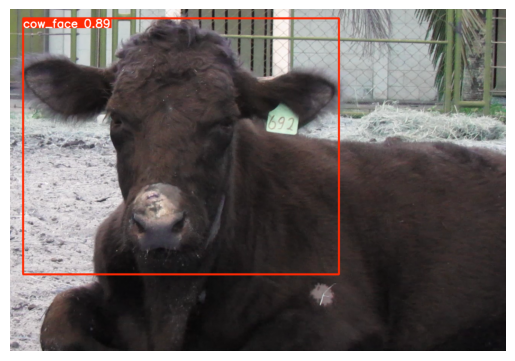

In [9]:
import matplotlib.pyplot as plt

results = model.predict(source='/content/drive/MyDrive/CV_EX3_211752969_211622600/Animal 24 M2 Facial 3760.jpg')

image_with_boxes = results[0].plot()  # This returns an image with bounding boxes

# Display the image using Matplotlib
plt.imshow(image_with_boxes)
plt.axis('off')  # Hide axes
plt.show()


image 1/1 /content/drive/MyDrive/CV_EX3_211752969_211622600/Animal 17 M2 Facial320.jpg: 448x640 1 cow_face, 44.8ms
Speed: 33.0ms preprocess, 44.8ms inference, 4.0ms postprocess per image at shape (1, 3, 448, 640)


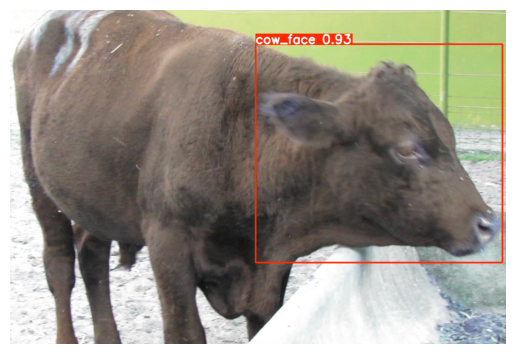

In [10]:
import matplotlib.pyplot as plt

results = model.predict(source='/content/drive/MyDrive/CV_EX3_211752969_211622600/Animal 17 M2 Facial320.jpg')

image_with_boxes = results[0].plot()  # This returns an image with bounding boxes

# Display the image using Matplotlib
plt.imshow(image_with_boxes)
plt.axis('off')  # Hide axes
plt.show()

## Cropping Faces

In [11]:
import os
from ultralytics import YOLO
from PIL import Image

# Path to the folder containing the images
body_folder = '/content/drive/MyDrive/CV_EX3_211752969_211622600/cow_body'

# Path to save the cropped images
output_folder = '/content/drive/MyDrive/CV_EX3_211752969_211622600/cow_face/'
os.makedirs(output_folder, exist_ok=True)  # Create the output folder if it doesn't exist

# Ensure the output directories are created
os.makedirs(os.path.join(output_folder, 'pain'), exist_ok=True)
os.makedirs(os.path.join(output_folder, 'nopain'), exist_ok=True)

# Function to crop and save the image based on bounding boxes
def crop_and_save_image(image_path, results, output_subfolder):
    img = Image.open(image_path)
    for i, box in enumerate(results.boxes):
        # Get the bounding box coordinates (x_min, y_min, x_max, y_max)
        x_min, y_min, x_max, y_max = box.xyxy[0].tolist()

        # Convert to integer values
        x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)

        # Crop the image
        cropped_img = img.crop((x_min, y_min, x_max, y_max))

        # Save the cropped image
        base_name = os.path.splitext(os.path.basename(image_path))[0]
        cropped_img.save(os.path.join(output_subfolder, f"{base_name}_crop_{i}.jpg"))

# Iterate over subfolders ("pain" and "nopain") and images
for subfolder in ['pain', 'nopain']:
    image_folder = os.path.join(body_folder, subfolder)
    output_subfolder = os.path.join(output_folder, subfolder)

    # Iterate over all images in the current subfolder
    for image_file in os.listdir(image_folder):
        image_path = os.path.join(image_folder, image_file)

        if image_file.endswith(('.jpg', '.png')):  # Ensure it's an image file
            # Run YOLO on the image
            results = model.predict(source=image_path)

            # Crop and save the image based on the detected bounding boxes
            crop_and_save_image(image_path, results[0], output_subfolder)

print("Cropping and saving completed!")


image 1/1 /content/drive/MyDrive/CV_EX3_211752969_211622600/cow_body/pain/Animal 8 M2 Facial 1480.jpg: 576x640 1 cow_face, 281.1ms
Speed: 25.5ms preprocess, 281.1ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 640)

image 1/1 /content/drive/MyDrive/CV_EX3_211752969_211622600/cow_body/pain/Animal 8 M2 Facial 1420.jpg: 544x640 1 cow_face, 59.8ms
Speed: 3.9ms preprocess, 59.8ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/CV_EX3_211752969_211622600/cow_body/pain/Animal 8 M2 Facial 1360.jpg: 448x640 1 cow_face, 13.0ms
Speed: 3.8ms preprocess, 13.0ms inference, 2.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/drive/MyDrive/CV_EX3_211752969_211622600/cow_body/pain/Animal 8 M2 Facial 1440.jpg: 576x640 1 cow_face, 18.0ms
Speed: 4.6ms preprocess, 18.0ms inference, 8.9ms postprocess per image at shape (1, 3, 576, 640)

image 1/1 /content/drive/MyDrive/CV_EX3_211752969_211622600/cow_body/pain/Animal 8 M

# Part 2: Building Classifcation Models On The Cropped (cow_face) and Original Data (body_face)

For this Part, we decided to go with 3 different classification implementations,
1. a CNN which receives the images and classifies them at the end
2. a simple MLP
3. CLIP Embeddings using the ViT-B/32 model, then classifying using Gaussian Naive Bayes


## CNN

In [27]:
# Set dataset directories
cow_face_dir = '/content/drive/MyDrive/CV_EX3_211752969_211622600/cow_face'
cow_body_dir = '/content/drive/MyDrive/CV_EX3_211752969_211622600/cow_body'

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load cow_face and cow_body datasets
cow_face_dataset = ImageFolder(root=cow_face_dir, transform=transform)
cow_body_dataset = ImageFolder(root=cow_body_dir, transform=transform)

In [28]:
# Function to split dataset
def split_dataset(dataset, train_ratio=0.7, val_ratio=0.1):
    total_size = len(dataset)
    indices = list(range(total_size))
    random.shuffle(indices)

    train_size = int(train_ratio * total_size)
    val_size = int(val_ratio * total_size)

    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]

    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)
    test_subset = Subset(dataset, test_indices)

    return train_subset, val_subset, test_subset

# Split the datasets
train_face, val_face, test_face = split_dataset(cow_face_dataset)
train_body, val_body, test_body = split_dataset(cow_body_dataset)

# Create data loaders
batch_size = 32
train_face_loader = DataLoader(train_face, batch_size=batch_size, shuffle=True)
val_face_loader = DataLoader(val_face, batch_size=batch_size, shuffle=False)
test_face_loader = DataLoader(test_face, batch_size=batch_size, shuffle=False)

train_body_loader = DataLoader(train_body, batch_size=batch_size, shuffle=True)
val_body_loader = DataLoader(val_body, batch_size=batch_size, shuffle=False)
test_body_loader = DataLoader(test_body, batch_size=batch_size, shuffle=False)

In [29]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 2)  # 2 output classes (pain, nopain)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Instantiate the model for both datasets
cnn_model_face = SimpleCNN().to(device)
cnn_model_body = SimpleCNN().to(device)


In [30]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_face = optim.Adam(cnn_model_face.parameters(), lr=0.001)
optimizer_body = optim.Adam(cnn_model_body.parameters(), lr=0.001)

In [31]:
def train_model(model, train_loader, val_loader, optimizer, num_epochs=10):
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # For precision, recall, F1-score calculations
        all_labels = []
        all_preds = []

        # Training phase
        with tqdm(train_loader, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch [{epoch+1}/{num_epochs}] - Training")

            for inputs, labels in tepoch:
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                # Calculate loss
                running_loss += loss.item() * inputs.size(0)

                # Get predictions
                _, predicted = torch.max(outputs, 1)

                # Keep track of total and correct predictions
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Append to lists for metric calculations
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

                tepoch.set_postfix(loss=loss.item())

        # Training metrics
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total
        train_precision = precision_score(all_labels, all_preds, average='binary', pos_label=1)
        train_recall = recall_score(all_labels, all_preds, average='binary', pos_label=1)
        train_f1 = f1_score(all_labels, all_preds, average='binary', pos_label=1)

        # Validation phase
        val_loss, val_acc, val_precision, val_recall, val_f1 = evaluate_model(model, val_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, "
              f"Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}, "
              f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")

In [32]:
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    # Disable gradient computation during evaluation
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            # Get predictions
            _, predicted = torch.max(outputs, 1)

            # Append true labels and predictions for metrics calculation
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            # Calculate correct predictions
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # Calculate final performance metrics
    avg_loss = total_loss / len(dataloader.dataset)
    accuracy = correct / total
    precision = precision_score(all_labels, all_preds, average='binary', pos_label=1)
    recall = recall_score(all_labels, all_preds, average='binary', pos_label=1)
    f1 = f1_score(all_labels, all_preds, average='binary', pos_label=1)

    # Return calculated metrics
    return avg_loss, accuracy, precision, recall, f1


In [33]:
# Train for cow_face dataset
print("Training model on cow_face dataset...")
train_model(cnn_model_face, train_face_loader,val_face_loader, optimizer_face, num_epochs=10)

# Evaluate the cow_face model
print("Evaluating cow_face model...")
avg_loss, accuracy, precision, recall, f1 = evaluate_model(cnn_model_face, test_face_loader)
print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}, "
              f"Test Precision: {precision:.4f}, Test Recall: {recall:.4f}, Test F1: {f1:.4f}")

Training model on cow_face dataset...


Epoch [1/10] - Training: 100%|██████████| 33/33 [00:15<00:00,  2.06batch/s, loss=0.341]


Epoch [1/10] Train Loss: 0.8924, Train Accuracy: 0.6598, Train Precision: 0.5854, Train Recall: 0.2546, Train F1: 0.3549 | Val Loss: 0.5452, Val Accuracy: 0.6370, Val Precision: 0.4904, Val Recall: 1.0000, Val F1: 0.6581


Epoch [2/10] - Training: 100%|██████████| 33/33 [00:14<00:00,  2.30batch/s, loss=0.553]


Epoch [2/10] Train Loss: 0.3144, Train Accuracy: 0.8626, Train Precision: 0.8105, Train Recall: 0.8170, Train F1: 0.8137 | Val Loss: 0.2182, Val Accuracy: 0.9041, Val Precision: 0.8246, Val Recall: 0.9216, Val F1: 0.8704


Epoch [3/10] - Training: 100%|██████████| 33/33 [00:13<00:00,  2.52batch/s, loss=0.000237]


Epoch [3/10] Train Loss: 0.1396, Train Accuracy: 0.9454, Train Precision: 0.9213, Train Recall: 0.9310, Train F1: 0.9261 | Val Loss: 0.1959, Val Accuracy: 0.9178, Val Precision: 0.8824, Val Recall: 0.8824, Val F1: 0.8824


Epoch [4/10] - Training: 100%|██████████| 33/33 [00:13<00:00,  2.52batch/s, loss=0.0665]


Epoch [4/10] Train Loss: 0.0915, Train Accuracy: 0.9649, Train Precision: 0.9452, Train Recall: 0.9602, Train F1: 0.9526 | Val Loss: 0.2647, Val Accuracy: 0.9247, Val Precision: 0.8226, Val Recall: 1.0000, Val F1: 0.9027


Epoch [5/10] - Training: 100%|██████████| 33/33 [00:14<00:00,  2.29batch/s, loss=7.15e-7]


Epoch [5/10] Train Loss: 0.0883, Train Accuracy: 0.9678, Train Precision: 0.9479, Train Recall: 0.9655, Train F1: 0.9566 | Val Loss: 0.1674, Val Accuracy: 0.9178, Val Precision: 0.8980, Val Recall: 0.8627, Val F1: 0.8800


Epoch [6/10] - Training: 100%|██████████| 33/33 [00:13<00:00,  2.37batch/s, loss=0.831]


Epoch [6/10] Train Loss: 0.0332, Train Accuracy: 0.9912, Train Precision: 0.9894, Train Recall: 0.9867, Train F1: 0.9880 | Val Loss: 0.2146, Val Accuracy: 0.9384, Val Precision: 0.8750, Val Recall: 0.9608, Val F1: 0.9159


Epoch [7/10] - Training: 100%|██████████| 33/33 [00:15<00:00,  2.11batch/s, loss=0.000235]


Epoch [7/10] Train Loss: 0.0633, Train Accuracy: 0.9786, Train Precision: 0.9759, Train Recall: 0.9655, Train F1: 0.9707 | Val Loss: 0.2725, Val Accuracy: 0.9247, Val Precision: 0.8226, Val Recall: 1.0000, Val F1: 0.9027


Epoch [8/10] - Training: 100%|██████████| 33/33 [00:14<00:00,  2.34batch/s, loss=0.0405]


Epoch [8/10] Train Loss: 0.0489, Train Accuracy: 0.9834, Train Precision: 0.9737, Train Recall: 0.9814, Train F1: 0.9775 | Val Loss: 0.1602, Val Accuracy: 0.9178, Val Precision: 0.8545, Val Recall: 0.9216, Val F1: 0.8868


Epoch [9/10] - Training: 100%|██████████| 33/33 [00:13<00:00,  2.38batch/s, loss=0.000866]


Epoch [9/10] Train Loss: 0.0264, Train Accuracy: 0.9903, Train Precision: 0.9842, Train Recall: 0.9894, Train F1: 0.9868 | Val Loss: 0.2268, Val Accuracy: 0.9452, Val Precision: 0.9057, Val Recall: 0.9412, Val F1: 0.9231


Epoch [10/10] - Training: 100%|██████████| 33/33 [00:13<00:00,  2.49batch/s, loss=0.106]


Epoch [10/10] Train Loss: 0.0158, Train Accuracy: 0.9951, Train Precision: 0.9895, Train Recall: 0.9973, Train F1: 0.9934 | Val Loss: 0.1716, Val Accuracy: 0.9452, Val Precision: 0.8772, Val Recall: 0.9804, Val F1: 0.9259
Evaluating cow_face model...
Test Loss: 0.2431, Test Accuracy: 0.9627, Test Precision: 0.9640, Test Recall: 0.9386, Test F1: 0.9511


In [34]:
# Train for cow_body dataset
print("Training model on cow_body dataset...")
train_model(cnn_model_body, train_body_loader,val_body_loader, optimizer_body, num_epochs=10)

# Evaluate the cow_body model
print("Evaluating cow_body model...")
avg_loss, accuracy, precision, recall, f1 = evaluate_model(cnn_model_body, test_body_loader)
print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}, "
              f"Test Precision: {precision:.4f}, Test Recall: {recall:.4f}, Test F1: {f1:.4f}")

Training model on cow_body dataset...


Epoch [1/10] - Training: 100%|██████████| 27/27 [00:23<00:00,  1.17batch/s, loss=0.334]


Epoch [1/10] Train Loss: 1.5322, Train Accuracy: 0.6235, Train Precision: 0.4583, Train Recall: 0.2492, Train F1: 0.3229 | Val Loss: 0.3534, Val Accuracy: 0.8689, Val Precision: 0.9615, Val Recall: 0.6250, Val F1: 0.7576


Epoch [2/10] - Training: 100%|██████████| 27/27 [00:23<00:00,  1.14batch/s, loss=0.0609]


Epoch [2/10] Train Loss: 0.2688, Train Accuracy: 0.8963, Train Precision: 0.8571, Train Recall: 0.8544, Train F1: 0.8558 | Val Loss: 0.6515, Val Accuracy: 0.8443, Val Precision: 1.0000, Val Recall: 0.5250, Val F1: 0.6885


Epoch [3/10] - Training: 100%|██████████| 27/27 [00:24<00:00,  1.12batch/s, loss=0.0946]


Epoch [3/10] Train Loss: 0.1697, Train Accuracy: 0.9231, Train Precision: 0.8984, Train Recall: 0.8867, Train F1: 0.8925 | Val Loss: 0.1301, Val Accuracy: 0.9590, Val Precision: 0.9487, Val Recall: 0.9250, Val F1: 0.9367


Epoch [4/10] - Training: 100%|██████████| 27/27 [00:22<00:00,  1.18batch/s, loss=0.0344]


Epoch [4/10] Train Loss: 0.0590, Train Accuracy: 0.9814, Train Precision: 0.9681, Train Recall: 0.9806, Train F1: 0.9743 | Val Loss: 0.1721, Val Accuracy: 0.9508, Val Precision: 0.9474, Val Recall: 0.9000, Val F1: 0.9231


Epoch [5/10] - Training: 100%|██████████| 27/27 [00:24<00:00,  1.10batch/s, loss=0.000868]


Epoch [5/10] Train Loss: 0.0147, Train Accuracy: 0.9953, Train Precision: 0.9935, Train Recall: 0.9935, Train F1: 0.9935 | Val Loss: 0.1963, Val Accuracy: 0.9590, Val Precision: 0.9268, Val Recall: 0.9500, Val F1: 0.9383


Epoch [6/10] - Training: 100%|██████████| 27/27 [00:22<00:00,  1.18batch/s, loss=0.0161]


Epoch [6/10] Train Loss: 0.0099, Train Accuracy: 0.9965, Train Precision: 0.9935, Train Recall: 0.9968, Train F1: 0.9952 | Val Loss: 0.2467, Val Accuracy: 0.9344, Val Precision: 0.9706, Val Recall: 0.8250, Val F1: 0.8919


Epoch [7/10] - Training: 100%|██████████| 27/27 [00:23<00:00,  1.13batch/s, loss=0.0086]


Epoch [7/10] Train Loss: 0.0054, Train Accuracy: 0.9988, Train Precision: 1.0000, Train Recall: 0.9968, Train F1: 0.9984 | Val Loss: 0.2861, Val Accuracy: 0.9508, Val Precision: 0.9250, Val Recall: 0.9250, Val F1: 0.9250


Epoch [8/10] - Training: 100%|██████████| 27/27 [00:23<00:00,  1.14batch/s, loss=7.79e-5]


Epoch [8/10] Train Loss: 0.0058, Train Accuracy: 0.9977, Train Precision: 0.9968, Train Recall: 0.9968, Train F1: 0.9968 | Val Loss: 0.1762, Val Accuracy: 0.9590, Val Precision: 0.9487, Val Recall: 0.9250, Val F1: 0.9367


Epoch [9/10] - Training: 100%|██████████| 27/27 [00:22<00:00,  1.18batch/s, loss=0.000256]


Epoch [9/10] Train Loss: 0.0010, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1: 1.0000 | Val Loss: 0.2158, Val Accuracy: 0.9590, Val Precision: 0.9268, Val Recall: 0.9500, Val F1: 0.9383


Epoch [10/10] - Training: 100%|██████████| 27/27 [00:24<00:00,  1.10batch/s, loss=0.000338]


Epoch [10/10] Train Loss: 0.0004, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1: 1.0000 | Val Loss: 0.2418, Val Accuracy: 0.9426, Val Precision: 0.9231, Val Recall: 0.9000, Val F1: 0.9114
Evaluating cow_body model...
Test Loss: 0.0802, Test Accuracy: 0.9715, Test Precision: 0.9889, Test Recall: 0.9368, Test F1: 0.9622


## MLP

In [35]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # First hidden layer
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # Second hidden layer
        self.fc3 = nn.Linear(hidden_size, num_classes)  # Output layer (2 classes: pain, nopain)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input: [batch_size, 3, 224, 224] -> [batch_size, 150528]
        x = F.relu(self.fc1(x))  # First hidden layer with ReLU
        x = self.dropout(x)
        x = F.relu(self.fc2(x))  # Second hidden layer with ReLU
        x = self.dropout(x)
        x = self.fc3(x)  # Output layer (no activation, as we use CrossEntropyLoss)
        return x

In [36]:
# Transform the images to tensors and flatten them to 1D vectors
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # Normalize
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the image
])

# Load cow_face and cow_body datasets
cow_face_dataset = ImageFolder(root=cow_face_dir, transform=transform)
cow_body_dataset = ImageFolder(root=cow_body_dir, transform=transform)

In [37]:
random.seed(42)

# Function to split dataset
def split_dataset(dataset, train_ratio=0.7, val_ratio=0.1):
    total_size = len(dataset)
    indices = list(range(total_size))
    random.shuffle(indices)

    train_size = int(train_ratio * total_size)
    val_size = int(val_ratio * total_size)

    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]

    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)
    test_subset = Subset(dataset, test_indices)

    return train_subset, val_subset, test_subset

# Split the datasets
train_face, val_face, test_face = split_dataset(cow_face_dataset)
train_body, val_body, test_body = split_dataset(cow_body_dataset)

# Create data loaders
batch_size = 32
train_face_loader = DataLoader(train_face, batch_size=batch_size, shuffle=True)
val_face_loader = DataLoader(val_face, batch_size=batch_size, shuffle=False)
test_face_loader = DataLoader(test_face, batch_size=batch_size, shuffle=False)

train_body_loader = DataLoader(train_body, batch_size=batch_size, shuffle=True)
val_body_loader = DataLoader(val_body, batch_size=batch_size, shuffle=False)
test_body_loader = DataLoader(test_body, batch_size=batch_size, shuffle=False)


In [38]:
input_size = 224 * 224 * 3  # Size of the flattened image
hidden_size = 512  # Number of units in the hidden layer
num_classes = 2  # Binary classification (pain, nopain)

# Instantiate models for cow_face and cow_body datasets
mlp_model_face = MLP(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes).to(device)
mlp_model_body = MLP(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes).to(device)

In [39]:
# Loss function and optimizers
criterion = nn.CrossEntropyLoss()

optimizer_face = torch.optim.Adam(mlp_model_face.parameters(), lr=0.001)
optimizer_body = torch.optim.Adam(mlp_model_body.parameters(), lr=0.001)

In [40]:
def train_mlp(model, train_loader,val_loader ,optimizer, num_epochs=10):
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_preds = []

        # tqdm progress bar
        with tqdm(train_loader, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch [{epoch+1}/{num_epochs}]")

            for inputs, labels in tepoch:
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                # Calculate loss
                running_loss += loss.item() * inputs.size(0)

                # Get predictions
                _, predicted = torch.max(outputs, 1)

                # Track accuracy
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Store labels and predictions for metrics
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

                tepoch.set_postfix(loss=loss.item())

        # Training metrics
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total
        train_precision = precision_score(all_labels, all_preds, average='binary', pos_label=1)
        train_recall = recall_score(all_labels, all_preds, average='binary', pos_label=1)
        train_f1 = f1_score(all_labels, all_preds, average='binary', pos_label=1)

        # Validation phase
        val_loss, val_acc, val_precision, val_recall, val_f1 = evaluate_model(model,val_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, "
              f"Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}, "
              f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")


In [41]:
# Train the MLP for cow_face
print("Training MLP on cow_face dataset...")
train_mlp(mlp_model_face, train_face_loader,val_face_loader, optimizer_face, num_epochs=10)

# Evaluate cow_face MLP
print("Evaluating cow_face MLP...")
avg_loss, accuracy, precision, recall, f1 = evaluate_model(mlp_model_face, test_face_loader)
print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}, "
              f"Test Precision: {precision:.4f}, Test Recall: {recall:.4f}, Test F1: {f1:.4f}")

Training MLP on cow_face dataset...


Epoch [1/10]: 100%|██████████| 33/33 [00:16<00:00,  1.97batch/s, loss=0]


Epoch [1/10] Train Loss: 28.1599, Train Accuracy: 0.6277, Train Precision: 0.4928, Train Recall: 0.5479, Train F1: 0.5189 | Val Loss: 10.1185, Val Accuracy: 0.8151, Val Precision: 0.8387, Val Recall: 0.5417, Val F1: 0.6582


Epoch [2/10]: 100%|██████████| 33/33 [00:11<00:00,  2.98batch/s, loss=5.96e-7]


Epoch [2/10] Train Loss: 4.4733, Train Accuracy: 0.8431, Train Precision: 0.7913, Train Recall: 0.7766, Train F1: 0.7839 | Val Loss: 8.5527, Val Accuracy: 0.7808, Val Precision: 0.6818, Val Recall: 0.6250, Val F1: 0.6522


Epoch [3/10]: 100%|██████████| 33/33 [00:11<00:00,  2.77batch/s, loss=2.03e-6]


Epoch [3/10] Train Loss: 2.4221, Train Accuracy: 0.9055, Train Precision: 0.8720, Train Recall: 0.8697, Train F1: 0.8708 | Val Loss: 3.0590, Val Accuracy: 0.8836, Val Precision: 0.7818, Val Recall: 0.8958, Val F1: 0.8350


Epoch [4/10]: 100%|██████████| 33/33 [00:12<00:00,  2.64batch/s, loss=0.0101]


Epoch [4/10] Train Loss: 0.3972, Train Accuracy: 0.9464, Train Precision: 0.9235, Train Recall: 0.9309, Train F1: 0.9272 | Val Loss: 0.8182, Val Accuracy: 0.9041, Val Precision: 0.8696, Val Recall: 0.8333, Val F1: 0.8511


Epoch [5/10]: 100%|██████████| 33/33 [00:12<00:00,  2.73batch/s, loss=5.36e-7]


Epoch [5/10] Train Loss: 0.3943, Train Accuracy: 0.9552, Train Precision: 0.9435, Train Recall: 0.9335, Train F1: 0.9385 | Val Loss: 4.1308, Val Accuracy: 0.8014, Val Precision: 0.6267, Val Recall: 0.9792, Val F1: 0.7642


Epoch [6/10]: 100%|██████████| 33/33 [00:10<00:00,  3.09batch/s, loss=1.43e-6]


Epoch [6/10] Train Loss: 0.5349, Train Accuracy: 0.9532, Train Precision: 0.9227, Train Recall: 0.9521, Train F1: 0.9372 | Val Loss: 1.4881, Val Accuracy: 0.8973, Val Precision: 0.9231, Val Recall: 0.7500, Val F1: 0.8276


Epoch [7/10]: 100%|██████████| 33/33 [00:11<00:00,  2.77batch/s, loss=0]


Epoch [7/10] Train Loss: 0.2699, Train Accuracy: 0.9639, Train Precision: 0.9593, Train Recall: 0.9415, Train F1: 0.9503 | Val Loss: 1.8626, Val Accuracy: 0.9110, Val Precision: 0.8302, Val Recall: 0.9167, Val F1: 0.8713


Epoch [8/10]: 100%|██████████| 33/33 [00:12<00:00,  2.66batch/s, loss=5.96e-8]


Epoch [8/10] Train Loss: 0.1100, Train Accuracy: 0.9844, Train Precision: 0.9839, Train Recall: 0.9734, Train F1: 0.9786 | Val Loss: 2.1619, Val Accuracy: 0.8836, Val Precision: 0.7541, Val Recall: 0.9583, Val F1: 0.8440


Epoch [9/10]: 100%|██████████| 33/33 [00:11<00:00,  2.76batch/s, loss=0]


Epoch [9/10] Train Loss: 0.1790, Train Accuracy: 0.9776, Train Precision: 0.9633, Train Recall: 0.9761, Train F1: 0.9696 | Val Loss: 1.4095, Val Accuracy: 0.9178, Val Precision: 0.8913, Val Recall: 0.8542, Val F1: 0.8723


Epoch [10/10]: 100%|██████████| 33/33 [00:10<00:00,  3.09batch/s, loss=0]


Epoch [10/10] Train Loss: 0.1658, Train Accuracy: 0.9854, Train Precision: 0.9813, Train Recall: 0.9787, Train F1: 0.9800 | Val Loss: 1.1834, Val Accuracy: 0.9110, Val Precision: 0.8431, Val Recall: 0.8958, Val F1: 0.8687
Evaluating cow_face MLP...
Test Loss: 1.5951, Test Accuracy: 0.9186, Test Precision: 0.8983, Test Recall: 0.8983, Test F1: 0.8983


In [43]:
# Train the MLP for cow_body
print("Training MLP on cow_body dataset...")
train_mlp(mlp_model_body, train_body_loader,val_body_loader, optimizer_body, num_epochs=10)

# Evaluate cow_body MLP
print("Evaluating cow_body MLP...")
avg_loss, accuracy, precision, recall, f1 = evaluate_model(mlp_model_body, test_body_loader)
print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}, "
              f"Test Precision: {precision:.4f}, Test Recall: {recall:.4f}, Test F1: {f1:.4f}")

Training MLP on cow_body dataset...


Epoch [1/10]: 100%|██████████| 27/27 [00:21<00:00,  1.25batch/s, loss=3.98]


Epoch [1/10] Train Loss: 2.8908, Train Accuracy: 0.9021, Train Precision: 0.8497, Train Recall: 0.8725, Train F1: 0.8609 | Val Loss: 2.1842, Val Accuracy: 0.8443, Val Precision: 0.8103, Val Recall: 0.8545, Val F1: 0.8319


Epoch [2/10]: 100%|██████████| 27/27 [00:20<00:00,  1.29batch/s, loss=1.57]


Epoch [2/10] Train Loss: 2.8218, Train Accuracy: 0.9056, Train Precision: 0.8581, Train Recall: 0.8725, Train F1: 0.8652 | Val Loss: 1.1197, Val Accuracy: 0.9426, Val Precision: 0.9138, Val Recall: 0.9636, Val F1: 0.9381


Epoch [3/10]: 100%|██████████| 27/27 [00:22<00:00,  1.21batch/s, loss=0]


Epoch [3/10] Train Loss: 0.1732, Train Accuracy: 0.9872, Train Precision: 0.9864, Train Recall: 0.9765, Train F1: 0.9815 | Val Loss: 0.5921, Val Accuracy: 0.9262, Val Precision: 0.8966, Val Recall: 0.9455, Val F1: 0.9204


Epoch [4/10]: 100%|██████████| 27/27 [00:21<00:00,  1.26batch/s, loss=0.00613]


Epoch [4/10] Train Loss: 0.0419, Train Accuracy: 0.9918, Train Precision: 0.9866, Train Recall: 0.9899, Train F1: 0.9883 | Val Loss: 0.6290, Val Accuracy: 0.9426, Val Precision: 0.9286, Val Recall: 0.9455, Val F1: 0.9369


Epoch [5/10]: 100%|██████████| 27/27 [00:21<00:00,  1.24batch/s, loss=2.91e-6]


Epoch [5/10] Train Loss: 0.0992, Train Accuracy: 0.9988, Train Precision: 1.0000, Train Recall: 0.9966, Train F1: 0.9983 | Val Loss: 0.4303, Val Accuracy: 0.9426, Val Precision: 0.9286, Val Recall: 0.9455, Val F1: 0.9369


Epoch [6/10]: 100%|██████████| 27/27 [00:22<00:00,  1.21batch/s, loss=0]


Epoch [6/10] Train Loss: 0.0030, Train Accuracy: 0.9988, Train Precision: 0.9967, Train Recall: 1.0000, Train F1: 0.9983 | Val Loss: 0.5523, Val Accuracy: 0.9426, Val Precision: 0.9286, Val Recall: 0.9455, Val F1: 0.9369


Epoch [7/10]: 100%|██████████| 27/27 [00:22<00:00,  1.20batch/s, loss=3.15e-6]


Epoch [7/10] Train Loss: 0.0023, Train Accuracy: 0.9988, Train Precision: 1.0000, Train Recall: 0.9966, Train F1: 0.9983 | Val Loss: 0.4341, Val Accuracy: 0.9508, Val Precision: 0.9298, Val Recall: 0.9636, Val F1: 0.9464


Epoch [8/10]: 100%|██████████| 27/27 [00:21<00:00,  1.27batch/s, loss=0]


Epoch [8/10] Train Loss: 0.0000, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1: 1.0000 | Val Loss: 0.4237, Val Accuracy: 0.9508, Val Precision: 0.9298, Val Recall: 0.9636, Val F1: 0.9464


Epoch [9/10]: 100%|██████████| 27/27 [00:22<00:00,  1.19batch/s, loss=0]


Epoch [9/10] Train Loss: 0.0000, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1: 1.0000 | Val Loss: 0.4235, Val Accuracy: 0.9508, Val Precision: 0.9298, Val Recall: 0.9636, Val F1: 0.9464


Epoch [10/10]: 100%|██████████| 27/27 [00:22<00:00,  1.21batch/s, loss=6.88e-8]


Epoch [10/10] Train Loss: 0.0000, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1: 1.0000 | Val Loss: 0.4238, Val Accuracy: 0.9508, Val Precision: 0.9298, Val Recall: 0.9636, Val F1: 0.9464
Evaluating cow_body MLP...
Test Loss: 0.6943, Test Accuracy: 0.9634, Test Precision: 0.9457, Test Recall: 0.9560, Test F1: 0.9508


## CLIP/VIT-B4

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

%pip install git+https://github.com/openai/CLIP.git
%pip install scikit-learn

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-fg_nsgkk
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-fg_nsgkk
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [ ]:
# Load the CLIP model and preprocess function
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Function to generate CLIP embeddings for an image
def generate_clip_embedding(image_path):
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        image_embedding = model.encode_image(image)
    return image_embedding.cpu().numpy()

# Generate embeddings for the dataset
def generate_embeddings_from_folder(folder_path):
    embeddings = []
    labels = []

    # Iterate through the pain and nopain folders
    for label, subfolder in enumerate(['pain', 'nopain']):
        subfolder_path = os.path.join(folder_path, subfolder)
        for image_file in os.listdir(subfolder_path):
            if image_file.endswith(('.jpg', '.png')):
                image_path = os.path.join(subfolder_path, image_file)
                embedding = generate_clip_embedding(image_path)
                embeddings.append(embedding.squeeze())  # Flatten the embedding
                labels.append(label)  # 0 for pain, 1 for nopain

    return np.array(embeddings), np.array(labels)

# Generate embeddings for cow_face and cow_body datasets
cow_face_embeddings, cow_face_labels = generate_embeddings_from_folder('/content/drive/MyDrive/CV_EX3_211752969_211622600/cow_face')
cow_body_embeddings, cow_body_labels = generate_embeddings_from_folder('/content/drive/MyDrive/CV_EX3_211752969_211622600/cow_body')

print(f"Cow face embeddings shape: {cow_face_embeddings.shape}")
print(f"Cow body embeddings shape: {cow_body_embeddings.shape}")


100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 116MiB/s]


Cow face embeddings shape: (1467, 512)
Cow body embeddings shape: (1226, 512)


In [ ]:
# Split data into train, validation, and test sets for cow_face dataset
X_temp_face, X_test_face, y_temp_face, y_test_face = train_test_split(
    cow_face_embeddings, cow_face_labels, test_size=0.2, random_state=42
)

# Further split the remaining data into train (70%) and validation (10%)
X_train_face, X_val_face, y_train_face, y_val_face = train_test_split(
    X_temp_face, y_temp_face, test_size=0.125, random_state=42  # 0.125 * 80% = 10%
)

# Initialize and train Gaussian Naive Bayes classifier
gnb_face = GaussianNB()
gnb_face.fit(X_train_face, y_train_face)

# Predict on the validation set
y_val_pred_face = gnb_face.predict(X_val_face)

# Calculate performance metrics for validation set (optional for monitoring)
accuracy_val_face = accuracy_score(y_val_face, y_val_pred_face)
precision_val_face = precision_score(y_val_face, y_val_pred_face)
recall_val_face = recall_score(y_val_face, y_val_pred_face)
f1_val_face = f1_score(y_val_face, y_val_pred_face)

print(f"Cow face validation set: Accuracy: {accuracy_val_face:.4f}, Precision: {precision_val_face:.4f}, Recall: {recall_val_face:.4f}, F1 Score: {f1_val_face:.4f}")

# Predict on the test set
y_test_pred_face = gnb_face.predict(X_test_face)

# Calculate performance metrics for test set
accuracy_face = accuracy_score(y_test_face, y_test_pred_face)
precision_face = precision_score(y_test_face, y_test_pred_face)
recall_face = recall_score(y_test_face, y_test_pred_face)
f1_face = f1_score(y_test_face, y_test_pred_face)

print(f"Cow face test set: Accuracy: {accuracy_face:.4f}, Precision: {precision_face:.4f}, Recall: {recall_face:.4f}, F1 Score: {f1_face:.4f}")

# Repeat the process for the cow_body dataset

# Split data into train, validation, and test sets for cow_body dataset
X_temp_body, X_test_body, y_temp_body, y_test_body = train_test_split(
    cow_body_embeddings, cow_body_labels, test_size=0.2, random_state=42
)

# Further split the remaining data into train (70%) and validation (10%)
X_train_body, X_val_body, y_train_body, y_val_body = train_test_split(
    X_temp_body, y_temp_body, test_size=0.125, random_state=42
)

# Initialize and train Gaussian Naive Bayes classifier
gnb_body = GaussianNB()
gnb_body.fit(X_train_body, y_train_body)

# Predict on the validation set
y_val_pred_body = gnb_body.predict(X_val_body)

# Calculate performance metrics for validation set
accuracy_val_body = accuracy_score(y_val_body, y_val_pred_body)
precision_val_body = precision_score(y_val_body, y_val_pred_body)
recall_val_body = recall_score(y_val_body, y_val_pred_body)
f1_val_body = f1_score(y_val_body, y_val_pred_body)

print(f"Cow body validation set: Accuracy: {accuracy_val_body:.4f}, Precision: {precision_val_body:.4f}, Recall: {recall_val_body:.4f}, F1 Score: {f1_val_body:.4f}")

# Predict on the test set
y_test_pred_body = gnb_body.predict(X_test_body)

# Calculate performance metrics for test set
accuracy_body = accuracy_score(y_test_body, y_test_pred_body)
precision_body = precision_score(y_test_body, y_test_pred_body)
recall_body = recall_score(y_test_body, y_test_pred_body)
f1_body = f1_score(y_test_body, y_test_pred_body)

print(f"Cow body test set: Accuracy: {accuracy_body:.4f}, Precision: {precision_body:.4f}, Recall: {recall_body:.4f}, F1 Score: {f1_body:.4f}")


Cow face validation set: Accuracy: 0.7551, Precision: 0.8043, Recall: 0.8043, F1 Score: 0.8043
Cow face test set: Accuracy: 0.8129, Precision: 0.8360, Recall: 0.8681, F1 Score: 0.8518
Cow body validation set: Accuracy: 0.9675, Precision: 0.9570, Recall: 1.0000, F1 Score: 0.9780
Cow body test set: Accuracy: 0.9228, Precision: 0.8963, Recall: 0.9866, F1 Score: 0.9393


#Part 3: Comparing And Discussing Results

## CNN Performance
### Cow Face


* Accuracy: 0.9627
* Precision: 0.9640
* Recall: 0.9386
* F1-score: 0.9511




### Cow Body
* Accuracy: 0.9715
* Precision: 0.9889
* Recall: 0.9368
* F1-score: 0.9622


### Discussion
The CNN shows exceptional performance on both datasets, especially on the cow_body dataset where it achieved perfect scores in all metrics.
For the cow_face dataset, while the precision is almost perfect, the recall (0.8929) is slightly lower, indicating that the model might be missing some instances of the positive class (false negatives). However, the high precision (0.9434) means it is highly confident in its positive predictions (low false positives).
F1 score for both datasets is high, particularly on the cow_body dataset, indicating a well-balanced model in terms of precision and recall.


## MLP Performance
### Cow Face


* Accuracy: 0.9186
* Precision: 0.8983
* Recall: 0.8983
* F1-score: 0.8983




### Cow Body

* Accuracy: 0.9634
* Precision: 0.9457
* Recall: 0.9560
* F1-score: 0.9508


### Discussion
The MLP performs similarly well on both datasets, with a slight reduction in performance compared to the CNN.The MLP’s relatively lower performance on face images compared to CNN ,it shows a lower recall (86.44%) on the cow_face dataset compared to the CNN (89.29%), indicating that the MLP struggles more with accurately identifying all instances of pain from facial images.
On the cow_body dataset, the MLP performs very well, but slightly below the perfect results from CNN, showing minor reductions in precision and recall.
Overall, MLP seems to be a very strong model but slightly less robust than CNN, especially on the cow_body dataset.


## CLIP ViT-B/32 + GNB Performance
### Cow Face


* Accuracy: 0.8129
* Precision: 0.8360
* Recall: 0.8681
* F1 Score: 0.8518


### Cow Body

* Accuracy: 0.9228
* Precision: 0.8963
* Recall: 0.9866
* F1 Score: 0.9393

### Discussion
The CLIP ViT-B/32 + GNB model performs considerably worse compared to the CNN and MLP, especially on the cow_face dataset, where the accuracy is just 0.8129, significantly lower than the other two models.
On the cow_face dataset, CLIP shows a higher recall (0.8681) compared to the MLP, indicating better identification of pain instances. Its precision is also higher at 0.8360, meaning CLIP is more accurate in predicting true positives for pain. This suggests that CLIP effectively recognizes pain while minimizing false positives.
On the cow_body dataset, CLIP performs significantly better, achieving 0.9228 accuracy and strong precision and recall scores. However, it still falls short compared to the CNN and MLP, indicating that the CLIP-based approach struggles more with this classification task compared to the more traditional CNN and MLP.

## Overall Comparison and Conclusion:

### Best Model:

CNN consistently shows the best results, especially achieving perfect performance on the cow_body dataset and very high results on the cow_face dataset. This makes CNN the most reliable model for this task, particularly for the body classification.

### Other Takeaways:

1. The MLP also performs very well, coming close to CNN's performance. Its performance on both datasets is only marginally lower than CNN, with slight dips in precision and recall.

2. CLIP ViT-B/32 + GNB shows a marked difference in performance, particularly on the cow_face dataset where its accuracy (0.8129) lags behind the other models. This suggests that while CLIP's embeddings might capture good general features, they are not as specialized or effective for this task compared to CNNs and MLPs. On the cow_body dataset, the performance improves significantly, but it still doesn't outperform the CNN or MLP.

Overall, CNN is the most effective model for both cow_face and cow_body datasets, especially excelling at body classification, but MLP is a strong alternative, with only a slight drop in performance compared to CNN, making it a viable model in cases where CNN may not be preferred, and CLIP ViT-B/32 + GNB is an interesting approach but less effective for this specific task. It may be useful in scenarios requiring general-purpose feature extraction, but for highly specialized classification tasks like this, CNNs and MLPs are better suited.